In [ ]:
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/budget.csv
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/cost.csv
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/participation.csv
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/work-package.csv
!wget -P ./plot_functions/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/plot_functions/budget.py
!wget -P ./plot_functions/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/plot_functions/consumed_budget.py
!wget -P ./plot_functions/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/plot_functions/cost.py

--2025-08-14 14:35:33--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/budget.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179 [text/plain]
Saving to: ‘./data/budget.csv.1’

budget.csv.1        100%[===================>]     179  --.-KB/s    in 0s      

2025-08-14 14:35:33 (11.0 MB/s) - ‘./data/budget.csv.1’ saved [179/179]

--2025-08-14 14:35:33--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/cost.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from plot_functions.budget import plot_projects_budget, plot_projects_budget_cumsum
from plot_functions.consumed_budget import plot_total_consumed_budget
from plot_functions.cost import (
    plot_staff_cumsum_cost,
    plot_staff_proportional_cost,
    plot_projects_total_cumsum_cost,
    plot_projects_stacked_cumsum_cost,
)


In [2]:
budget_df = pd.read_csv('data/budget.csv')
budget_df["start"] = pd.to_datetime(budget_df["start"])
budget_df["end"] = pd.to_datetime(budget_df["end"])
budget_df["duration"] = budget_df["end"] - budget_df["start"]
budget_df

,project,start,end,budget,duration
0,Kinder,2024-01-01,2025-06-30,20000,546 days
1,TAP,2026-01-01,2028-06-30,30000,911 days
2,web,2025-01-01,2035-10-30,4000,3954 days
3,p2,2024-09-01,2026-10-30,9400,789 days
4,p3,2028-01-01,2029-10-30,9400,668 days


In [3]:
participation_df = pd.read_csv('data/participation.csv')
participation_df

,project,work-package,staff,participation
0,Kinder,NaN,bidar,0.1
1,Kinder,NaN,ali,0.3
2,Kinder,NaN,hassan,0.4
3,Kinder,NaN,hamid,0.0
4,TAP,NaN,bidar,0.3
5,TAP,0.0,bidar,0.4
6,TAP,0.0,ali,0.3
7,TAP,1.0,hassan,0.1
8,TAP,2.0,hassan,0.3
9,TAP,1.0,hamid,0.4


In [4]:
participation_df[participation_df["work-package"].isna()]

,project,work-package,staff,participation
0,Kinder,NaN,bidar,0.1
1,Kinder,NaN,ali,0.3
2,Kinder,NaN,hassan,0.4
3,Kinder,NaN,hamid,0.0
4,TAP,NaN,bidar,0.3
11,web,NaN,bidar,0.1
12,web,NaN,ali,0.2
13,web,NaN,hassan,0.1
14,web,NaN,hamid,0.1
15,p3,NaN,ali2,0.5


In [5]:
cost_df = pd.read_csv('data/cost.csv')
cost_df

,staff,monthly-rate,start,end
0,bidar,600,2024-01-01,2026-01-30
1,ali,300,2024-09-01,2025-04-30
2,hassan,200,2026-10-02,2027-09-30
3,hamid,100,2024-06-02,2036-09-30
4,ali2,200,2025-01-01,2031-04-30


In [6]:
work_package_df = pd.read_csv('data/work-package.csv')
work_package_df

,project,id,budget,package_name,start,end,status
0,web,0,100,Initial Planning,2023-01-01,2023-02-15,Completed
1,web,1,200,Design Phase,2023-02-16,2023-04-30,In Progress
2,TAP,0,3000,Development Sprint 1,2024-03-01,2024-08-15,In Progress
3,TAP,1,5000,Quality Assurance,2024-04-16,2024-10-31,Pending
4,TAP,2,6000,Documentation,2024-05-01,2025-06-15,Not Started


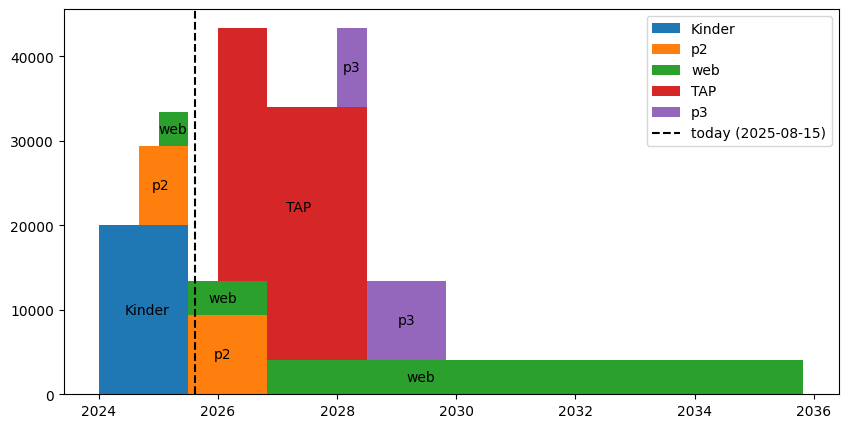

In [7]:
priority_type = "start"   # choices are budget - start - duration
priority_ascending = True # choices are False - True
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_projects_budget(budget_df, priority_type, priority_ascending,ax=ax)
plt.show()

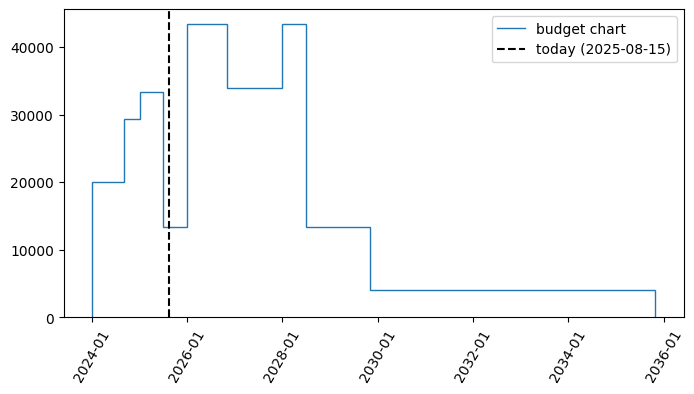

In [8]:
plot_projects_budget_cumsum(budget_df)
plt.show()

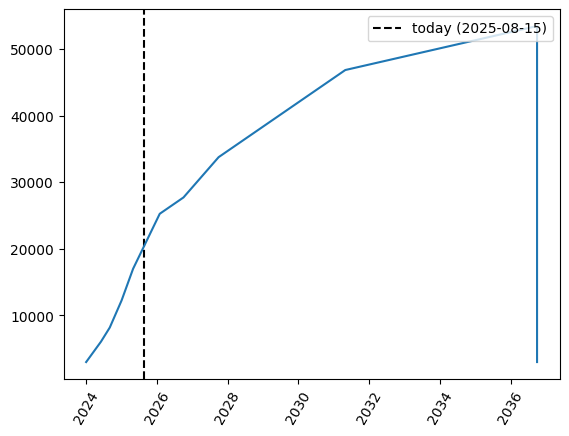

In [9]:
plot_staff_cumsum_cost(cost_df, 3000)
plt.show()

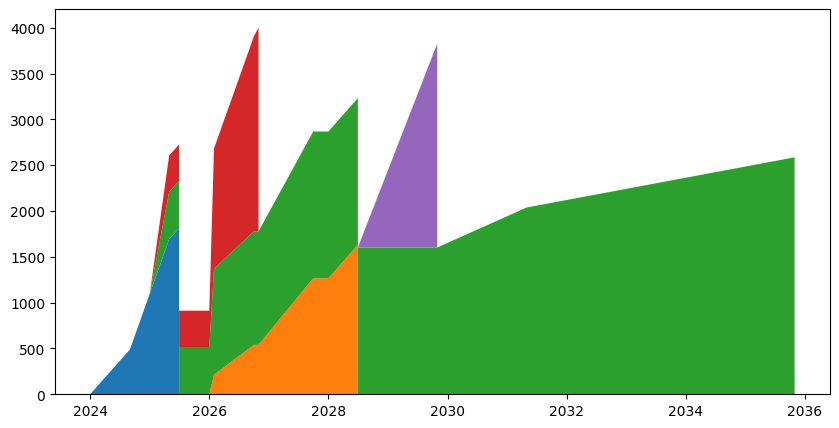

In [10]:

fig, ax = plt.subplots(figsize=(10, 5))


plot_projects_stacked_cumsum_cost(participation_df, cost_df, budget_df, ax)
plt.show()

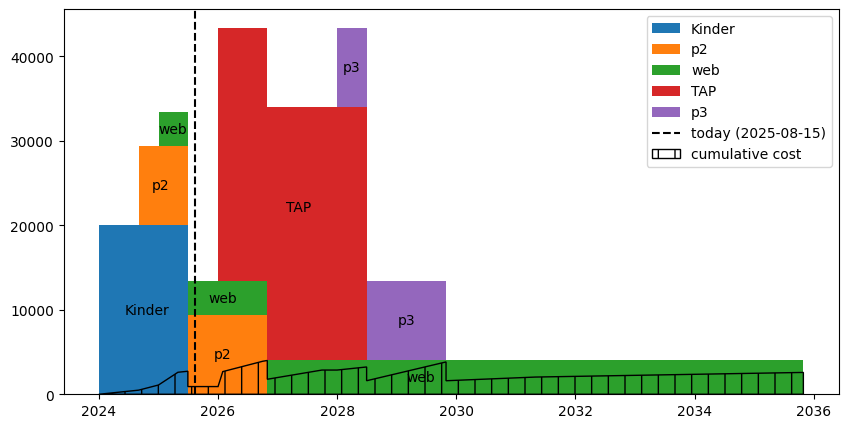

In [11]:

fig, ax = plt.subplots(figsize=(10, 5))
plot_projects_budget(budget_df, priority_type, priority_ascending, ax=ax)
plot_projects_total_cumsum_cost(
    participation_df,
    cost_df,
    budget_df,
    ax,
    color="none",
    edgecolor="black",
    hatch="|",
    label="cumulative cost",
)
plt.legend()
plt.show()

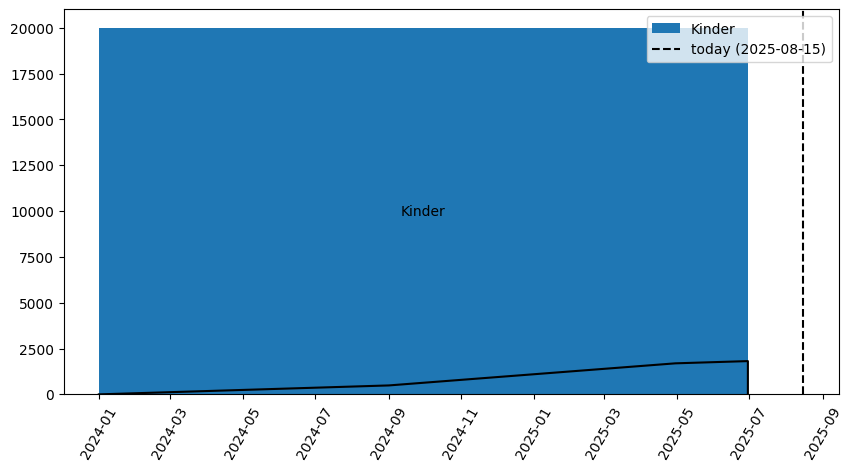

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_projects_budget(
    budget_df[budget_df["project"] == "Kinder"], priority_type, priority_ascending, ax=ax
)
plot_staff_proportional_cost(
    participation_df,
    cost_df,
    budget_df,
    "Kinder",
    ax=ax,
    color="black",
    plot_today=False,
)
plt.show()

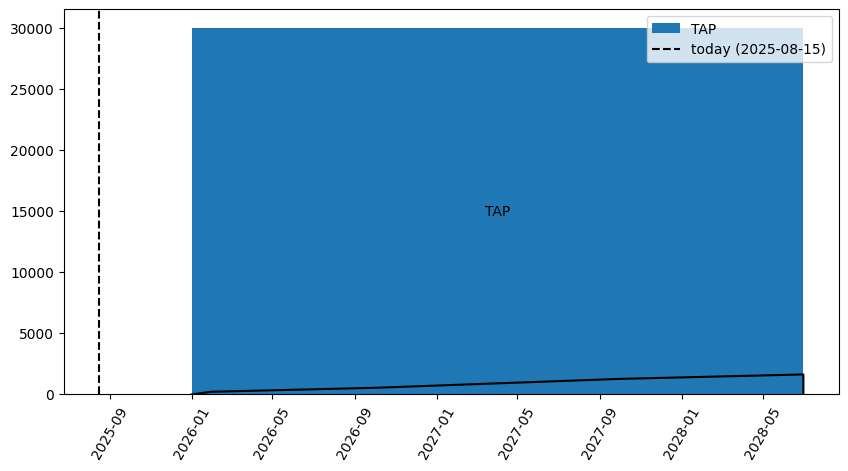

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_projects_budget(
    budget_df[budget_df["project"] == "TAP"], priority_type, priority_ascending, ax=ax
)
plot_staff_proportional_cost(
    participation_df,
    cost_df,
    budget_df,
    "TAP",
    ax=ax,
    color="black",
    plot_today=False,
)
plt.show()

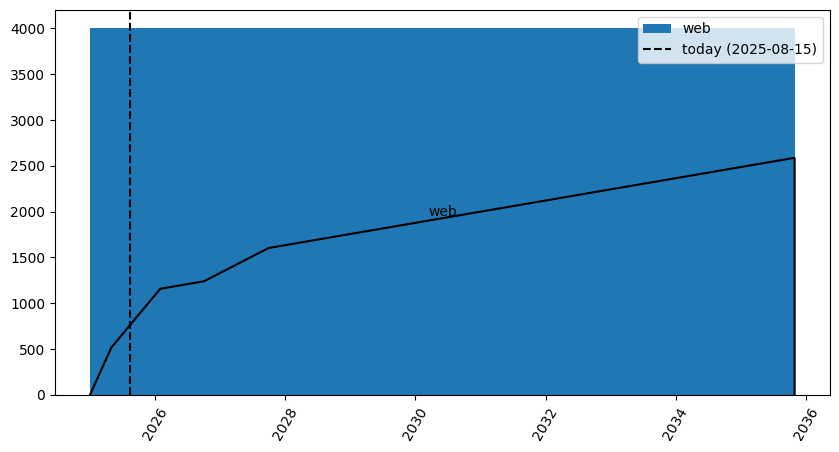

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_projects_budget(
    budget_df[budget_df["project"] == "web"], priority_type, priority_ascending, ax=ax
)
plot_staff_proportional_cost(
    participation_df,
    cost_df,
    budget_df,
    "web",
    ax=ax,
    color="black",
    plot_today=False,
)
plt.show()

<Axes: >

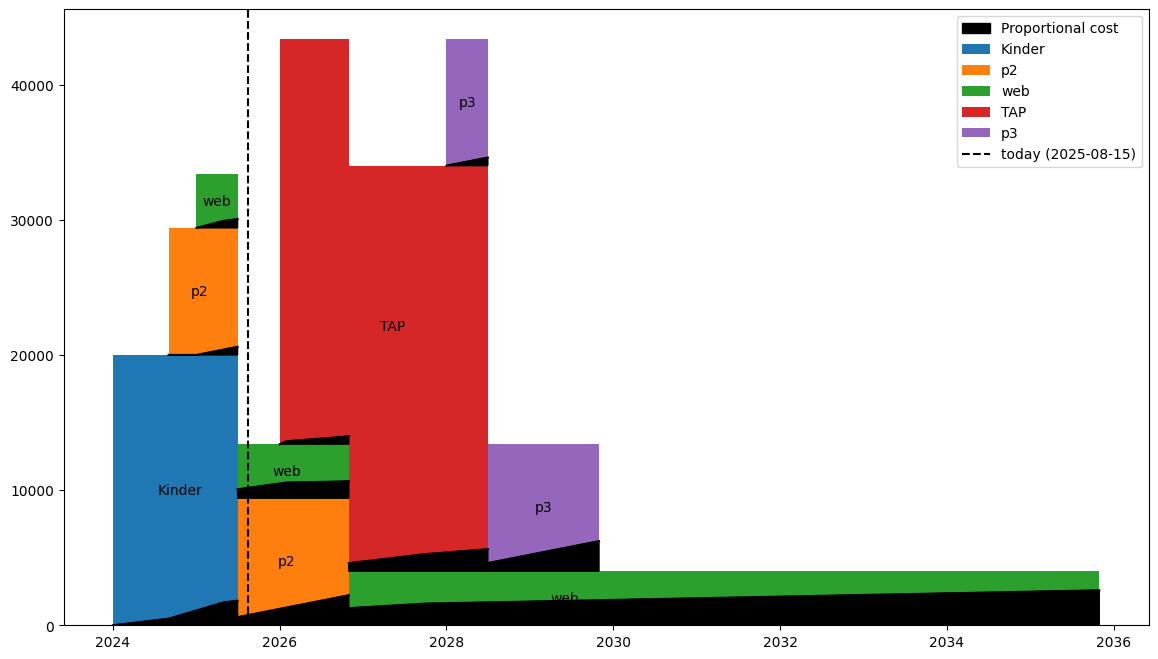

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))

plot_total_consumed_budget(
    participation_df, cost_df, budget_df, priority_type, priority_ascending, ax
)

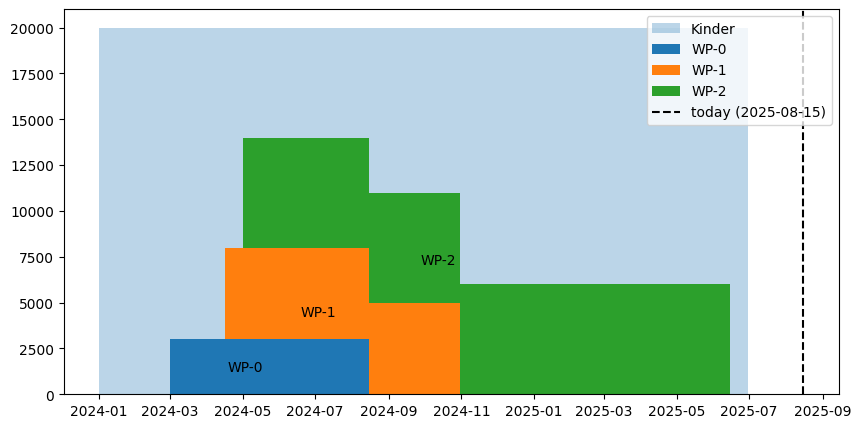

In [16]:
from plot_functions.budget import get_budget_stack_data, plot_work_package_budget
import numpy as np

from plot_functions.consumed_budget import plot_project_consumed_budget

fig, ax = plt.subplots(figsize=(10, 5))

x, y, labels = get_budget_stack_data(
    budget_df[budget_df["project"] == "Kinder"], priority_type, priority_ascending
)

x = np.insert(x, 0, x[0])
y = np.insert(y[0], 0, 0)
ax.fill_between(x, y, step="post", label="Kinder", alpha=0.3)
plot_work_package_budget(
    work_package_df[work_package_df["project"] == "TAP"],
    priority_type,
    priority_ascending,
    ax,
)

plt.legend(loc="upper right")
plt.show()

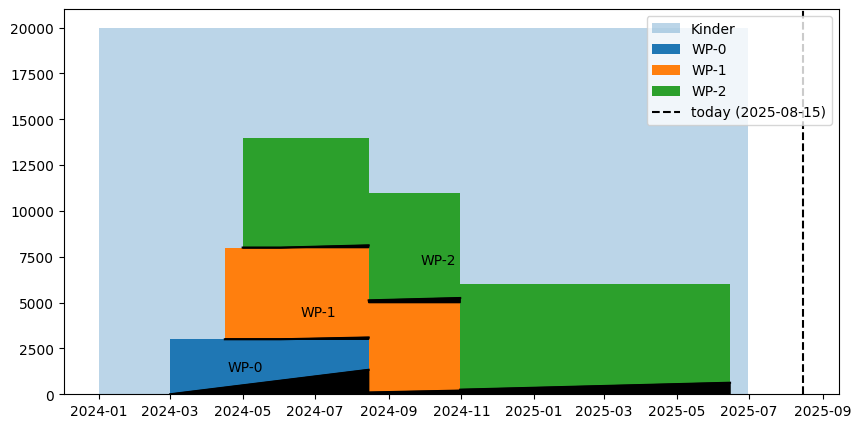

In [19]:
from plot_functions.budget import get_budget_stack_data
import numpy as np

from plot_functions.consumed_budget import plot_project_consumed_budget

fig, ax = plt.subplots(figsize=(10, 5))

x, y, labels = get_budget_stack_data(
    budget_df[budget_df["project"] == "Kinder"], priority_type, priority_ascending
)

x = np.insert(x, 0, x[0])
y = np.insert(y[0], 0, 0)
ax.fill_between(x, y, step="post", label="Kinder", alpha=0.3)

plot_project_consumed_budget(
    participation_df,
    cost_df,
    work_package_df,
    "TAP",
    priority_type,
    priority_ascending,
    ax,
)

plt.legend(loc="upper right")
plt.show()